Hinweis: Es ist deutlich komfortabler, die Skripte für Alex bzw ResNext direkt in der Konsole auszuführen. Dafür gehen sie am besten in den Ordner in denen diese Liegen (src/) und führen es über <br>
```python3 trainer_alexnet.py``` <br>
bzw <br>
```python3 trainer_resnext.py```<br>
aus

Dieses Script lädt den Datensatz von Kaggle herunter, sollte er noch nicht vorhanden sein. Dieses Script schlägt fehl, wenn kein kaggle.json am richtigen Ort hinterlegt ist. In Google Colab ist dieser Pfad /root/.kaggle/kaggle.json

In [4]:
# %load dataset_downloader.py
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import zipfile


#Funktionalität zum Downloaden des Datensatzes von Kaggle, falls er noch nicht vorhanden ist
if not os.path.exists("dataset"):
    api = KaggleApi()
    api.authenticate()

    api.dataset_download_files('patrickaudriaz/tobacco3482jpg')


    with zipfile.ZipFile("tobacco3482jpg.zip","r") as z:
        z.extractall("dataset/")
    

Dataloader Klasse

In [5]:
# %load dataloader.py
import os
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
import cv2
import torch
from random import shuffle

#kleine Helperklasse, welche ein Bild darstellt. 
#Sie hilft den Zugriff auf die Future Objekte zu kapseln
class Image:
    def __init__(self, future):
        self.future = future
        self.image = None

    def show(self):
        if self.image is None:
            self.image=self.future.result()
        cv2.imshow('',self.image.numpy()[0])
        cv2.waitKey(1000)

    def get_tensor(self):
        if self.image is None:
            self.image=self.future.result()
        return self.image


#funktion, welche ein Bild von einem Pfad (image) zu laden, die größe auf 227x227 anzupassen
#und in einen Torch tensor zu laden, um es dann auf die Grafikkarte zu laden
def load(image, scale):
    img = cv2.imread(image,0)
    if scale is not None:
        img = cv2.resize(img, scale, interpolation = cv2.INTER_AREA)
    img = torch.from_numpy(img)
    img = torch.stack([img,img,img])
    return img.float().cuda()/255


#dataloader Klasse, welche Daten asynchron lädt
class Dataloader:

    #initialisiere alle Daten und scanne die Ordnerhierarche, um
    #daraus die Kategorien abzuleiten
    def __init__(self, path):
        self.path = path
        self.categories = os.listdir(self.path)
        self.files = {}
        self.executor = ThreadPoolExecutor(max_workers = 8)
        self.count = 0
        self.smallest_category = 1e9
        for category in self.categories:
            images = os.listdir(self.path + "/" + category)
            images = list(filter(lambda x: x.find(".jpg") != -1, images))
            shuffle(images)
            self.files[category] = images
            self.smallest_category = min(self.smallest_category, len(images))

    #falls das dataloader Objekt gelöscht wird, stoppe auch den threadpoolexecutor, sonst
    #terminiert das Programm gegebenenfalls nicht
    def __del__(self):
        self.executor.shutdown(wait=True)

    #der dataloader soll auch als contextmanager funktionieren, um den Zustand (count) einfacher zurückzusetzen.
    def __enter__(self):
        self.count = 0
    
    def __exit__(self,type, value, traceback):
        pass
    
    
    #lade "nr" anzahl von Datenpunkten und skaliere sie auf die Größe "scale". Scale ist dabei ein Tupel.
    #Das laden ist dabei asynchron, diese Funktion hier blockt also nicht
    def load(self, nr, scale):
        loaded_images = {}
        for category in self.categories:
            result = []
            for i in range(nr):
                future = self.executor.submit(load, "".join((self.path, "/", category, "/", self.files[category][self.count+i] )) ,scale)
                image = Image(future)
                result.append(image)
            loaded_images[category] = result
        self.count += nr
        return loaded_images
            

Die beiden Modelle für AlexNet und ResNext

In [6]:
# %load model.py

import torch
import torch.nn as nn
from torchvision import models

#Alexnet Classifier, aber tausche das letzte Layer des Netzwerks aus, um 
#einen Klassifikator für 10 Klassen zu erhalten
class AlexNetClassifier(nn.Module):
    def __init__(self):
        super(AlexNetClassifier, self).__init__()
        alex = models.alexnet(pretrained = True)
        self.feature_extraction = nn.Sequential(*list(alex.features.children()))
        self.classifier = nn.Sequential(*list(alex.classifier.children())[:-1])
        self.final_layer = nn.Linear(4096, 10)

    #forward funktion des Netzwerks.
    def forward(self, x, train_feature_extraction=False):
        N, C, H, W = x.shape
        #wenn gewuenscht deaktiviere die Gradienten für die feature Extraction
        #das ermöglicht es nur den classifier zu trainieren, ohne die 
        #vortrainierten Gewichte der Feature Extraction zu beschädigen
        if train_feature_extraction:
            x = self.feature_extraction(x)
        else:
            x = self.feature_extraction(x).detach()  
        x = self.classifier(x.view(N, -1))
        x = self.final_layer(x)
        return x


#das gleiche nochmal für ResNext. Siehe dazu den Bericht
class ResNextClassifier(nn.Module):
    def __init__(self):
        super(ResNextClassifier, self).__init__()
        resnext = models.resnext50_32x4d(pretrained = True)
        self.net = nn.Sequential(*list(resnext.children())[:-1])
        self.final_layer = nn.Linear(2048, 10)

    def forward(self, x, train_feature_extraction=False):
        N, C, H, W = x.shape
        if train_feature_extraction:
            x = self.net(x)
        else:
            x = self.net(x).detach()  
        x = self.final_layer(x.view(N, -1))
        return x

Container Klasse für die Confusion Matrix

In [7]:
# %load confusion_matrix.py

from collections import defaultdict 
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt


#Klasse für die Confusion Matrix
#sie speichert die nötigen Informationen zum Berechnen der 
#accuracy und bietet außerdem die Möglichkeit die confusion Matrix grafisch anzuzeigen.
#Die Matrix speichert allerdings absolute Werte und (noch) keine Prozente. Die 
#werden erst beim Zugriff auf die Daten berechnet
class ConfusionMatrix():
    #initialisiere alle nötigen Datenstrukturen
    #Die Matrix selbst ist dabei ein dictionary, das dictionarys enthält.
    #Nutze dafür defaultdicts, um sich das Initialisieren zu sparen
    def __init__(self):
        self.matrix = defaultdict(lambda: defaultdict(lambda:0))
        self.classcount = defaultdict(lambda: 0)
        self.count = 0

    #implementiere __getitem__ um Matrix über den [] Operator nutzen zu können
    def __getitem__(self, key):
        return self.matrix[key]

    #addiere eine Liste von Ergebnissen zur Matrix hinzu
    def add(self,ground_truth_list,prediction_list):
        for ground_truth, prediction in zip(ground_truth_list, prediction_list):
            self[prediction][ground_truth] +=1
            self.count +=1
            self.classcount[ground_truth] +=1
    
    #accuracy ist die summe der Diagonale geteilt durch die Gesamtzahl der eingetragenen Messwerte
    def get_accuracy(self, all_labels):
        correct = 0
        for label in all_labels:
            correct += self[label][label]

        return correct / self.count

    #plotte die Matrix als Heatmap
    def plot_matrix(self):
        df = pd.DataFrame(self.matrix)
        df = df.fillna(0)
        df = df.reindex(sorted(df.columns), axis=1)
        df = df.sort_index()
        classcount_df = pd.DataFrame(self.classcount, index = [0])
        df=df.div(classcount_df.iloc[0])

        sn.heatmap(df, cmap = sn.color_palette("light:b", as_cmap=True), annot = True)
        # plt.show()

    #plotte die Accuracy pro Klasse als Barchart
    def plot_barplot(self, categories):
        data = {category:self.matrix[category][category]/self.classcount[category] for category in categories}
        df = pd.DataFrame(data, index = [0])
        df = df.reindex(sorted(df.columns), axis=1)
        sn.catplot(color="#004686", data=df, kind = "bar")

        # plt.show()


gelegentlich könnte der Grafikspeicher voll laufen, insbesondere weil jupyter den global space nicht richtig aufräumt. Zur Sicherheit wenigstens den torch cache aufräumen

In [8]:
torch.cuda.empty_cache()

Dies ist das Skript, welches das Alexnet trainiert und die grafiken erstellt.


train for sample_size=20


epoch 0 loss: 47.67562961578369  accuracy: 0.305
epoch 1 loss: 38.419835567474365  accuracy: 0.505
epoch 2 loss: 31.86397433280945  accuracy: 0.595
epoch 3 loss: 27.895511150360107  accuracy: 0.605
epoch 4 loss: 25.31324017047882  accuracy: 0.635
epoch 5 loss: 23.465651273727417  accuracy: 0.645
epoch 6 loss: 22.044104516506195  accuracy: 0.65
epoch 7 loss: 20.88585466146469  accuracy: 0.65
epoch 8 loss: 19.911976873874664  accuracy: 0.65
epoch 9 loss: 19.06618821620941  accuracy: 0.65
epoch 10 loss: 18.316956281661987  accuracy: 0.65
epoch 11 loss: 17.24171644449234  accuracy: 0.64
epoch 12 loss: 15.569259017705917  accuracy: 0.66
epoch 13 loss: 13.966692626476288  accuracy: 0.665
epoch 14 loss: 12.516693115234375  accuracy: 0.66
epoch 15 loss: 11.325819343328476  accuracy: 0.665
epoch 16 loss: 10.266445070505142  accuracy: 0.66
epoch 17 loss: 9.37725880742073  accuracy: 0.67
epoch 18 loss: 8.605118289589882  accuracy: 0.66
epoch 19 loss: 7.968173585832119 

epoch 3 loss: 101.16373288631439  accuracy: 0.71
epoch 4 loss: 94.73949658870697  accuracy: 0.71
epoch 5 loss: 89.53082329034805  accuracy: 0.715
epoch 6 loss: 85.10048016905785  accuracy: 0.725
epoch 7 loss: 81.21415492892265  accuracy: 0.72
epoch 8 loss: 77.75708490610123  accuracy: 0.72
epoch 9 loss: 74.6113953590393  accuracy: 0.725
epoch 10 loss: 71.73433694243431  accuracy: 0.725
epoch 11 loss: 71.83893758058548  accuracy: 0.73
epoch 12 loss: 63.98586843907833  accuracy: 0.765
epoch 13 loss: 57.32940948009491  accuracy: 0.765
epoch 14 loss: 51.471058659255505  accuracy: 0.77
epoch 15 loss: 46.55434337258339  accuracy: 0.76
epoch 16 loss: 42.328670650720596  accuracy: 0.77
epoch 17 loss: 38.0012850984931  accuracy: 0.78
epoch 18 loss: 34.30853106081486  accuracy: 0.785
epoch 19 loss: 31.191684007644653  accuracy: 0.795
epoch 20 loss: 29.08580758422613  accuracy: 0.8
epoch 21 loss: 26.97103825956583  accuracy: 0.785
epoch 22 loss: 25.38967126980424  accuracy: 0.77
epoch 23 loss: 25

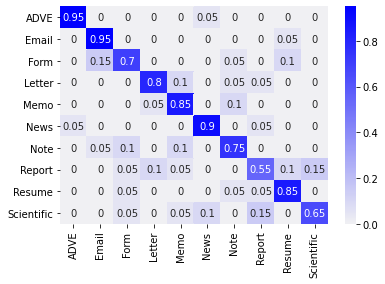

<Figure size 432x288 with 0 Axes>

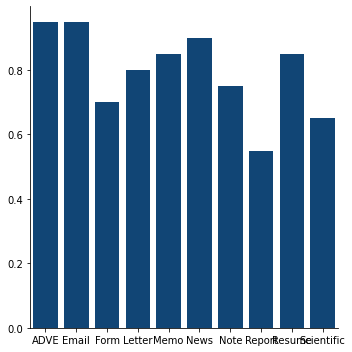

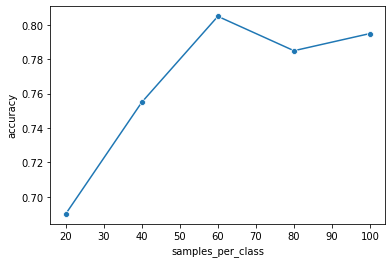

In [9]:
# %load trainer_alexnet.py
#prüfe ob code von konsole oder in jupyter notebook läuft und 
#importiere andere files nur wenn es in konsole ist
from IPython import get_ipython
if get_ipython() is None:   
    from model import AlexNetClassifier, ResNextClassifier
    from dataloader import Dataloader
    from confusion_matrix import ConfusionMatrix
#importiere Abhängigkeiten
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sn

def run():
    #groeße des Testsplits
    test_size = 20

    #erzeuge Dataloader Instanz
    dloader = Dataloader("dataset/tobacco3482-jpg/Tobacco3482-jpg")

    #Funktion um geladene Daten in Batches einzuteilen
    #dabei enthält jeder Batch wie im Paper 10 Datenpunkte. 
    #in diese Implementierung exakt einer pro Klasse
    def prepare_batches(data, categories):
        num_batches = len(data[categories[0]])
        batches = []
        for i in range(num_batches):
            batch = []
            for category in categories:
                batch.append(data[category][i].get_tensor())
            batches.append(torch.stack(batch))
        return batches

    #da es immer exakt ein Datenpunkt pro Klasse in einem Batch sind, 
    #kann man das target fix auf [1,2,3,...,10] setzen
    target = torch.arange(10).cuda()

    #deklariere Datencontainer für das Printen des Accuracy Graphs
    data_for_accuracy_graph_y = []
    data_for_accuracy_graph_x = []

    #wiederhole die folgenden Messungen mehrfach, mit verschiedener anzahl Samples pro Klasse
    for sample_size in range(20, 101, 20):
        print("\ntrain for sample_size=" + str(sample_size) + "\n\n")
        with dloader:
            #das Netzwerk muss für jede Messung neu Initialisiert werden, 
            #um Overfit und ungewolltes Pretraining zu vermeiden
            net = AlexNetClassifier().cuda()
            #lade test und train splits
            #dloader merkt sich welche Daten schon geladen wurden. test und train sind also disjunkt
            test_split = dloader.load(test_size, (227,227))
            train_split = dloader.load(sample_size, (227,227)) 

            #teile train split in batches ein
            batches = prepare_batches(train_split ,dloader.categories)

            #loss und optimizer fürs trainieren des Netzes
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

            #setze Netzwerk in train Modus
            net.train()

            #trainiere für 40 Epochen
            for epoch in range(40):
                running_loss = 0

                #trainiere einen Batch
                for batch in batches:

                    #Gib dem netzwerk die Information mit, ob es gerade die ersten 10 Epochen trainiert.
                    #Ist das der Fall, sind die Gradienten für die Feature Extraction des Netzes deaktiviert.
                    #Das friert die Feature Extraction beim Training ein. 
                    #Das schützt die vortrainierten Parameter, bis 
                    #der Klassifikator genug konvergiert ist
                    output = net(batch, epoch > 10).cuda()
                    loss = criterion(output.cuda(), target)
                    loss.backward()
                    optimizer.step()
                    # print(loss)
                    running_loss += loss.item()
                    optimizer.zero_grad()
                #teile auch den test Datensatz in batches ein. Das ist eigentlich nicht nötig, 
                #weil sowieso alles in die Grafikkarte passt.
                #Es war auf diese Weise aber etwas leichter zu implementieren, 
                #weil alle Funktionen bereits für das Training implementiert wurden
                test_batches = prepare_batches(test_split, dloader.categories)
                #setze Netzwerk in evaluation Mode
                net.eval()
                #initialisiere Confusion Matrix
                confusion_matrix = ConfusionMatrix()
                #evaluiere alle testbatches, bestimme die Klasse 
                #und speichere das Ergebnis in confusion Matrix
                for batch in test_batches:
                    pred = F.softmax(net(batch),dim=0).argmax(dim=0)
                    # print(pred)
                    pred = [dloader.categories[x.item()] for x in pred]
                    confusion_matrix.add(dloader.categories, pred)
                
                #lese accuracy aus confusion matrix aus (=Summe der Diagonale)
                accuracy = confusion_matrix.get_accuracy(dloader.categories)

                #speichere accuracy und sample size, um es später als Graph anzuzeigen

                print("epoch " + str(epoch) +  " loss: " + str(running_loss) + "  accuracy: " + str(accuracy))
            data_for_accuracy_graph_y.append(accuracy)
            data_for_accuracy_graph_x.append(sample_size)

    #plotte die Ergebnisse und zeige sie an
    plt.figure()
    confusion_matrix.plot_matrix()
    plt.figure()
    confusion_matrix.plot_barplot(dloader.categories)
    plt.figure()
    df = pd.DataFrame({"samples_per_class":data_for_accuracy_graph_x, "accuracy": data_for_accuracy_graph_y})
    print(df)
    sn.lineplot(
        data=df,
        x="samples_per_class", y="accuracy",
        marker="o", ci=None
    )
    plt.show()
if __name__ == "__main__":
    run()

räume nochmal den torch cache auf

In [14]:
torch.cuda.empty_cache()

das Skript, welches ResNext trainiert sieht prinzipiell exakt genauso aus wie das für Alexnet, bis auf kleinere Änderungen

epoch 0 loss: 224.2033395767212  accuracy: 0.295
epoch 1 loss: 212.47411143779755  accuracy: 0.405
epoch 2 loss: 199.6735234260559  accuracy: 0.5
epoch 3 loss: 188.80347442626953  accuracy: 0.56
epoch 4 loss: 179.53218829631805  accuracy: 0.615
epoch 5 loss: 171.52069520950317  accuracy: 0.64
epoch 6 loss: 164.51797354221344  accuracy: 0.655
epoch 7 loss: 158.33595263957977  accuracy: 0.67
epoch 8 loss: 152.83077728748322  accuracy: 0.675
epoch 9 loss: 147.89087557792664  accuracy: 0.67
epoch 10 loss: 143.42843914031982  accuracy: 0.675
epoch 11 loss: 139.37335419654846  accuracy: 0.68
epoch 12 loss: 135.6688631772995  accuracy: 0.68
epoch 13 loss: 132.26846873760223  accuracy: 0.68
epoch 14 loss: 129.13365590572357  accuracy: 0.685
epoch 15 loss: 126.23222750425339  accuracy: 0.69
epoch 16 loss: 123.53702354431152  accuracy: 0.69
epoch 17 loss: 121.02497625350952  accuracy: 0.685
epoch 18 loss: 118.67635381221771  accuracy: 0.69
epoch 19 loss: 116.47417879104614  accuracy: 0.685
epoch

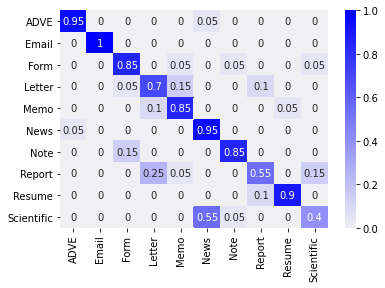

<Figure size 432x288 with 0 Axes>

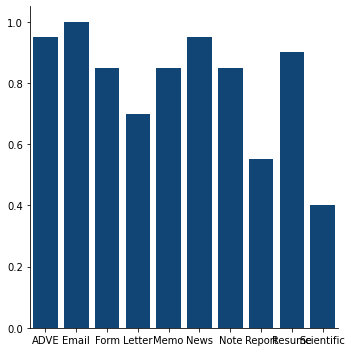

<Figure size 432x288 with 0 Axes>

In [1]:
# %load trainer_resnext.py
#prüfe ob code von konsole oder in jupyter notebook läuft und importiere andere files nur wenn es in konsole ist
from IPython import get_ipython  
from model import AlexNetClassifier, ResNextClassifier
from dataloader import Dataloader
from confusion_matrix import ConfusionMatrix
#importiere Abhängigkeiten
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sn

def run():
    #groeße des Testsplits
    test_size = 20

    #erzeuge Dataloader Instanz
    dloader = Dataloader("dataset/tobacco3482-jpg/Tobacco3482-jpg")

    #Funktion um geladene Daten in Batches einzuteilen
    #dabei enthält jeder Batch wie im Paper 10 Datenpunkte. 
    #in diese Implementierung exakt einer pro Klasse
    def prepare_batches(data, categories):
        num_batches = len(data[categories[0]])
        batches = []
        for i in range(num_batches):
            batch = []
            for category in categories:
                batch.append(data[category][i].get_tensor())
            batches.append(torch.stack(batch))
        return batches

    #da es immer exakt ein Datenpunkt pro Klasse in einem Batch sind, kann man das target fix auf [1,2,3,...,10] setzen
    target = torch.arange(10).cuda()


    sample_size = 100
    with dloader:
        #das Netzwerk muss für jede Messung neu Initialisiert werden, um Overfit und ungewolltes Pretraining zu vermeiden
        net = ResNextClassifier().cuda()
        #lade test und train splits
        #dloader merkt sich welche Daten schon geladen wurden. test und train sind also disjunkt
        test_split = dloader.load(test_size, (227,227))
        train_split = dloader.load(sample_size, (227,227)) 

        #teile train split in batches ein
        batches = prepare_batches(train_split ,dloader.categories)

        #loss und optimizer fürs trainieren des Netzes
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

        #setze Netzwerk in train Modus
        net.train()

        #trainiere für 40 Epochen
        for epoch in range(40):
            running_loss = 0

            #trainiere einen Batch
            for batch in batches:

                #Gib dem netzwerk die Information mit, ob es gerade die ersten 10 Epochen trainiert.
                #Ist das der Fall, sind die Gradienten für die Feature Extraction des Netzes deaktiviert.
                #Das friert die Feature Extraction beim Training ein. Das schützt die vortrainierten Parameter, bis 
                #der Klassifikator genug konvergiert ist
                output = net(batch, epoch > 20).cuda()
                loss = criterion(output.cuda(), target)
                loss.backward()
                optimizer.step()
                # print(loss)
                running_loss += loss.item()
                optimizer.zero_grad()
            #teile auch den test Datensatz in batches ein. Das ist eigentlich nicht nötig, weil sowieso alles in die Grafikkarte passt.
            #Es war auf diese Weise aber etwas leichter zu implementieren, weil alle Funktionen bereits für das Training implementiert wurden
            test_batches = prepare_batches(test_split, dloader.categories)
            #setze Netzwerk in evaluation Mode
            net.eval()
            #initialisiere Confusion Matrix
            confusion_matrix = ConfusionMatrix()
            #evaluiere alle testbatches, bestimme die Klasse und speichere das Ergebnis in confusion Matrix
            for batch in test_batches:
                pred = F.softmax(net(batch),dim=0).argmax(dim=0)
                # print(pred)
                pred = [dloader.categories[x.item()] for x in pred]
                confusion_matrix.add(dloader.categories, pred)
            
            #lese accuracy aus confusion matrix aus (=Summe der Diagonale)
            accuracy = confusion_matrix.get_accuracy(dloader.categories)

            #speichere accuracy und sample size, um es später als Graph anzuzeigen

            print("epoch " + str(epoch) +  " loss: " + str(running_loss) + "  accuracy: " + str(accuracy))


    #plotte die Ergebnisse und zeige sie an
    plt.figure()
    confusion_matrix.plot_matrix()
    plt.figure()
    confusion_matrix.plot_barplot(dloader.categories)
    plt.figure()
    plt.show()


if __name__ == "__main__":
    run()